In [ ]:
import pandas as pd
import sys, os
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Only need to run this cell when using Google Colab
# Install a Drive FUSE wrapper.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# Only need to run this cell when using Google Colab
# mount Google drive


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
from google.colab import drive
if (os.path.isdir('/content/gdrive')==False):
  drive.mount('/content/gdrive')
basepath = '/content/gdrive/My Drive'
sys.path.insert(0, basepath)
os.chdir(basepath)

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('./creditcard.csv')

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
# Normalize Amount column (It seems the other columns are normalized)
data['scaledAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
# Drop Time and Amount column
data = data.drop(['Time','Amount'],axis=1)

% of frauds: 0.17 % of the dataset


Text(0, 0.5, 'Frequency')

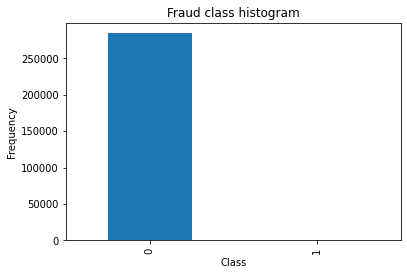

In [ ]:
num_fraud = data['Class'].value_counts()[1]
print('% of frauds:', round(num_fraud/len(data) * 100,2), '% of the dataset')
# Plot number of fraud and legit records
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [ ]:
num_fraud

492

In [ ]:
def train_model(X_train, y_train):
    # Split training for 5-fold validation
    sss = StratifiedShuffleSplit(n_splits=5, random_state=20)
    # Logistic Regression
    model = LogisticRegression(solver='liblinear')
    # Random grid search on hyperparameters
    params = {"penalty": ['l1', 'l2'], 'C': [0.1, 1, 10, 100]}
    '''
    To optimize precision-recall score (average precision score)
    AP summarizes a precision-recall curve as the weighted mean of precisions 
    achieved at each threshold, with the increase in recall from the previous 
    threshold used as the weight
    '''
    scoring = {'ave_prec': 'average_precision'}
    n_iter = 6
    grid_search = RandomizedSearchCV(model, params,scoring=scoring,random_state= 50,refit='ave_prec',cv=sss,n_iter=n_iter,verbose=1,n_jobs=-1)
    
    start = time() # start time
    lr_fit = grid_search.fit(X_train, y_train)
    lr_best = grid_search.best_estimator_
    end = time() # end time
    # Calculate training time
    search_time = (end-start)/60.
    print('--'*30)
    print('Took {0:.2f} minutes to find optimal parameters'.format(search_time))
    print('Best parameters for model: {}'.format(lr_fit.best_params_))
    print('Best precision-recall socre from training: {}'.format(lr_fit.best_score_))
    return lr_best

In [ ]:
def predict_test(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_test_pred))
    print("Classification Report")
    print(classification_report(y_test, y_test_pred))
    print('--'*30)
    # Plot precision-recall curve
    # Compute precision-recall pairs for different probability threshold
    precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test))
    plt.figure(figsize=(12,6))
    plt.plot(recall, precision, c='b' )
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    pr_score = average_precision_score(y_test, model.decision_function(X_test))
    plt.title('Test PR curve: \n Average Precision-Recall Score ={0:0.2f}'.format(pr_score, fontsize=14))
    plt.grid(b=True, which='major', c='g', linestyle='-', alpha=0.2)
    plt.show()

In [ ]:
print(model_smote.score(X_test,y_test))


0.976949545310909


In [ ]:
print(model_regular.score(X_test,y_test))


0.9990695551420246


In [ ]:
print(model_smote.r2_score(y_test,y_))
print(model_smote.r2_score(X_test,y_test))


In [ ]:
# Separate labels from features
X = data.loc[:,data.columns!='Class']
y = data['Class']
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


------------------------------------------------------------
Took 2.20 minutes to find optimal parameters
Best parameters for model: {'penalty': 'l2', 'C': 0.1}
Best precision-recall socre from training: 0.7642589240077233
Confusion Matrix
[[56855     9]
 [   44    54]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.55      0.67        98

    accuracy                           1.00     56962
   macro avg       0.93      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------


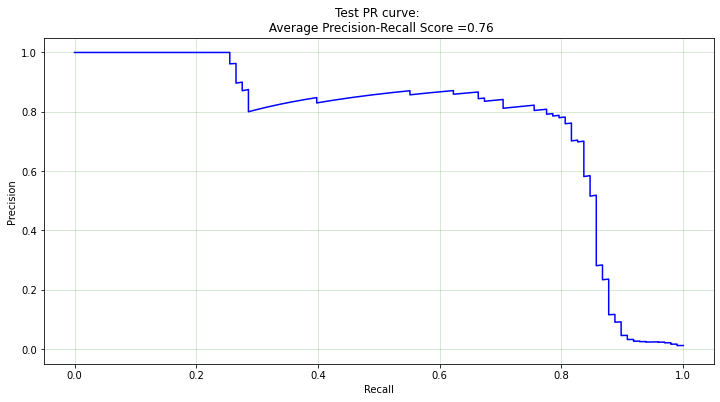

In [ ]:
# -----------  Train and test imbalanced datasets ----------
model_regular = train_model(X_train, y_train)
predict_test (model_regular, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.9min finished


------------------------------------------------------------
Took 4.98 minutes to find optimal parameters
Best parameters for model: {'penalty': 'l2', 'C': 10}
Best precision-recall socre from training: 0.9889253796586308
Confusion Matrix
[[55559  1305]
 [    8    90]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

------------------------------------------------------------


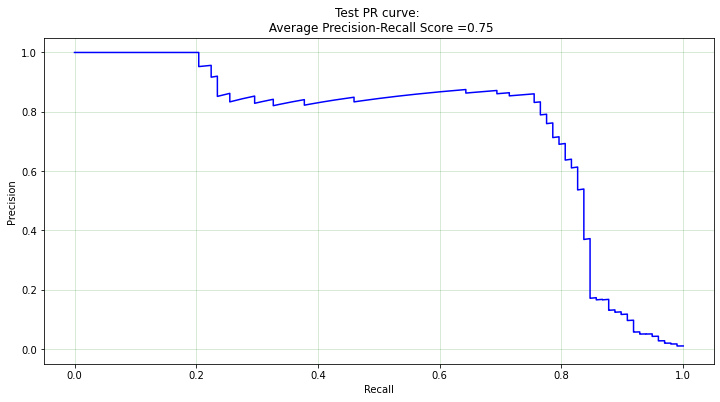

In [ ]:
# -----------  SMOTE (Synthetic Minority Over-sampling Technique) ----------
X_train_smote, y_train_smote = SMOTE(sampling_strategy='minority').fit_resample(X_train, y_train)
model_smote = train_model(X_train_smote, y_train_smote)
predict_test (model_smote, X_test, y_test)

In [ ]:
print(model_smote.score(X_test,y_test))


0.976949545310909


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
pred=knn.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,pred))

[[56840    24]
 [   20    78]]


In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.85      0.62        98

    accuracy                           1.00     56962
   macro avg       0.75      0.92      0.81     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
knn.score(X_test,y_test)

0.9982444436641972

In [ ]:
pr_score = average_precision_score(y_test, knn.predict(X_test))


In [ ]:
knn5 = KNeighborsClassifier(n_neighbors=5)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracy_rate = []
X_smote, y_smote = SMOTE(sampling_strategy='minority').fit_resample(X, y)
# Will take some time
for i in range(1,10):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X_smote, y_smote,cv=10)
    accuracy_rate.append(score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
error_rate=[]

for i in range(1,10):
  knn=KNeighborsClassifier(n_neighbours=i)
  knn.fit(X_train_smote, y_train_smote)
  pred_i=knn.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))

TypeError: ignored

In [ ]:
plt.figure(figsize=(10,6))
#plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
  #       markerfacecolor='red', markersize=10)
plt.plot(range(1,10),accuracy_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
rand_clf=RandomForestClassifier(random_state=6)
rand_clf.fit(X_train_smote,y_train_smote)
rand_clf.score(X_test,y_test)

0.9995084442259752

In [ ]:
print(confusion_matrix(y_test,rand_clf.predict(y_test))

In [ ]:
print(classification_report(y_test,rand_clf.predict(y_test)))

In [ ]:
grid_param = {
    "n_estimators" : [90,100,115,130],
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,20,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'max_features' : ['auto','log2']
}

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV
grid_search = GridSearchCV(estimator=rand_clf,param_grid=grid_param,cv=5,n_jobs =-1,verbose = 3)

In [ ]:
grid_search.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 20736 candidates, totalling 103680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 94.6min


In [ ]:
grid_search.best_params_


In [ ]:
##find random forest best paramenters by grid search.fit()